<a href="https://colab.research.google.com/github/AlfonsoCastilloFlores/IB_IA_AD2024_1970709/blob/main/PRACTICA4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize # para algoritmo de optimización

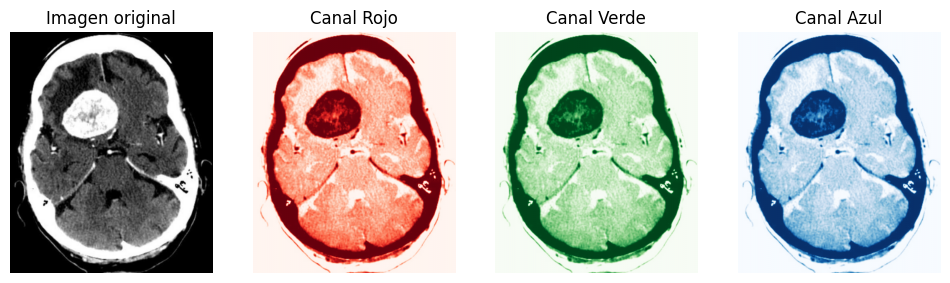

In [3]:
# Cargar imagen a color
img = cv2.imread('/content/platano.jpg')  # Cambia 'imagen.jpg' por la ruta de tu imagen
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR (OpenCV) a RGB

# Separar canales
R, G, B = img_rgb[:, :, 0], img_rgb[:, :, 1], img_rgb[:, :, 2]

# Mostrar los canales por separado
plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.imshow(img_rgb)
plt.title('Imagen original')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(R, cmap='Reds')
plt.title('Canal Rojo')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(G, cmap='Greens')
plt.title('Canal Verde')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(B, cmap='Blues')
plt.title('Canal Azul')
plt.axis('off')
plt.show()

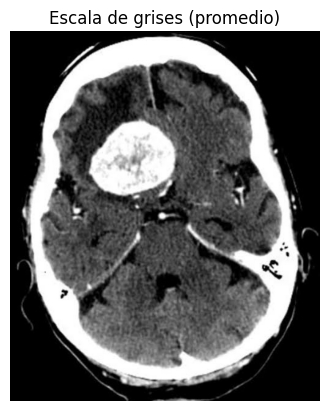

In [4]:
# Convertir a escala de grises promediando canales
gray_avg = ((R.astype(np.float32) + G + B) / 3).astype(np.uint8)

# Mostrar imagen en escala de grises
plt.imshow(gray_avg, cmap='gray')
plt.title('Escala de grises (promedio)')
plt.axis('off')
plt.show()

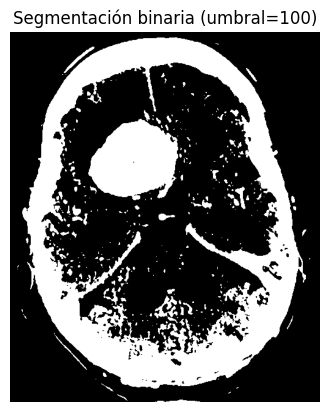

In [5]:
# Umbral para segmentación
umbral = 100
_, segmentada = cv2.threshold(gray_avg, umbral, 255, cv2.THRESH_BINARY)

# Mostrar imagen segmentada
plt.imshow(segmentada, cmap='gray')
plt.title(f'Segmentación binaria (umbral={umbral})')
plt.axis('off')
plt.show()


**Segmentación** **Óptima** **SLSQP**

In [6]:
# Cargar imagen y convertir de BGR a RGB
img = cv2.imread('/content/platano.jpg')  # Cambia el nombre de la imagen
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
R, G, B = img_rgb[:, :, 0], img_rgb[:, :, 1], img_rgb[:, :, 2]

In [7]:
# Normalizar canales entre 0 y 1
R_norm = R.astype(np.float32) / 255
G_norm = G.astype(np.float32) / 255
B_norm = B.astype(np.float32) / 255

# Función objetivo: varianza negativa (porque minimize() minimiza)
def grayscale_variance(weights):
    w_r, w_g, w_b = weights
    gray = w_r * R_norm + w_g * G_norm + w_b * B_norm
    gray_normalized = (gray - gray.min()) / (gray.max() - gray.min())
    return -np.var(gray_normalized)  # Negativo para maximizar

# Restricción: suma de pesos debe ser 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Límites de cada peso: entre 0 y 1
bounds = [(0, 1), (0, 1), (0, 1)]

# Valor inicial
initial_weights = [0.33, 0.33, 0.34]

# Optimización
result = minimize(grayscale_variance, initial_weights, method='SLSQP',
                  bounds=bounds, constraints=constraints)

optimal_weights = result.x
print("Pesos óptimos:", optimal_weights)


Pesos óptimos: [0.33 0.33 0.34]


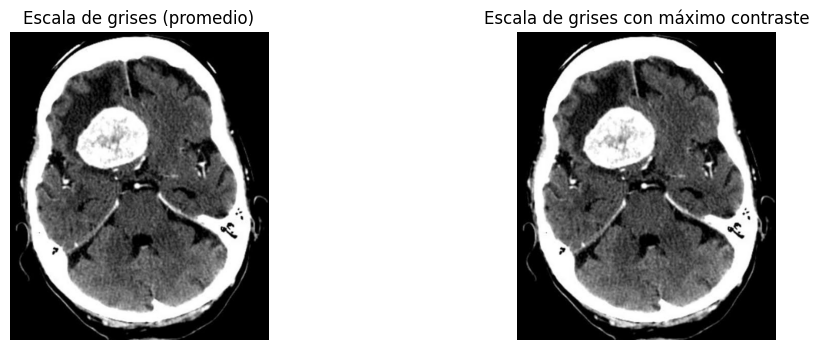

In [9]:
# Crear imagen en escala de grises con pesos óptimos
gray_optimal = optimal_weights[0] * R_norm + optimal_weights[1] * G_norm + optimal_weights[2] * B_norm
gray_optimal = (gray_optimal * 255).astype(np.uint8)

# Mostrar resultado
# Imagen obtenida de manera directa o sencilla
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(gray_avg, cmap='gray')
plt.title('Escala de grises (promedio)')
plt.axis('off')

# Imagen obtenida de manera óptima
plt.subplot(1, 2, 2)
plt.imshow(gray_optimal, cmap='gray')
plt.title('Escala de grises con máximo contraste')
plt.axis('off')
plt.show()

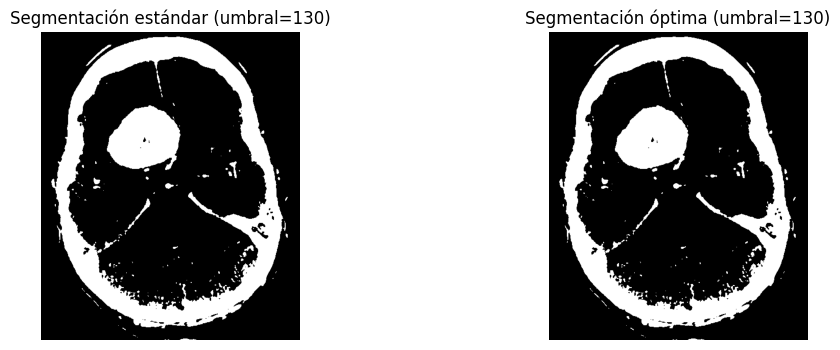

In [40]:
# Segmentar ambas imágenes con un mismo umbral
umbral = 130
_, seg_standard = cv2.threshold(gray_avg, umbral, 255, cv2.THRESH_BINARY)
_, seg_optimal = cv2.threshold(gray_optimal, umbral, 255, cv2.THRESH_BINARY)

# Mostrar resultado
# Imagen obtenida de manera directa o sencilla
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(seg_standard, cmap='gray')
plt.title(f'Segmentación estándar (umbral={umbral})')
plt.axis('off')

# Imagen obtenida de manera óptima
plt.subplot(1, 2, 2)
plt.imshow(seg_optimal, cmap='gray')
plt.title(f'Segmentación óptima (umbral={umbral})')
plt.axis('off')
plt.show()

**RUIDO**

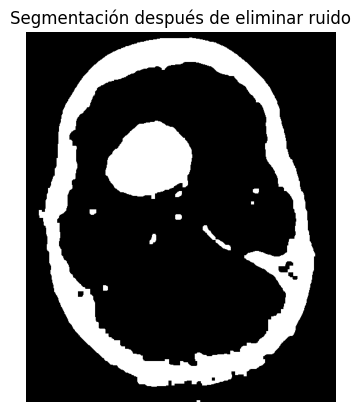

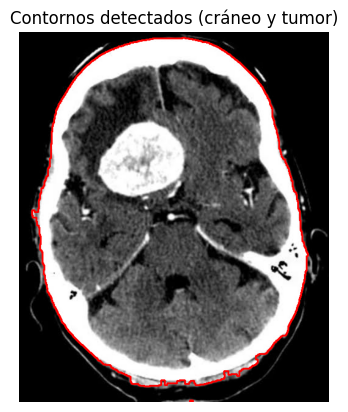

In [48]:
# Eliminación de ruido con operaciones morfológicas
kernel = np.ones((5, 5), np.uint8)
limpia = cv2.morphologyEx(seg_optimal, cv2.MORPH_OPEN, kernel)  # elimina ruido pequeño
limpia = cv2.morphologyEx(limpia, cv2.MORPH_CLOSE, kernel)      # cierra huecos internos

# Mostrar imagen limpia
plt.imshow(limpia, cmap='gray')
plt.title('Segmentación después de eliminar ruido')
plt.axis('off')
plt.show()

# Encontrar contornos
contornos, _ = cv2.findContours(limpia, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Dibujar contornos sobre imagen original
img_contornos = img_rgb.copy()
cv2.drawContours(img_contornos, contornos, -1, (255, 0, 0), 2)  # azul: contornos

# Mostrar resultado
plt.imshow(img_contornos)
plt.title('Contornos detectados (cráneo y tumor)')
plt.axis('off')
plt.show()


**AREA**

In [52]:
# Calcular área de cada contorno
areas = [cv2.contourArea(c) for c in contornos]

# Mostrar área de cada uno
for i, area in enumerate(areas):
    print(f"Área del contorno {i+1}: {area:.2f} píxeles")

# Encontrar el área máxima (probable tumor)
area_max = max(areas)
print(f"\nÁrea del tumor estimada: {area_max:.2f} píxeles")


Área del contorno 1: 10.00 píxeles
Área del contorno 2: 198719.50 píxeles

Área del tumor estimada: 198719.50 píxeles


Área del tumor detectado: 336.5 píxeles


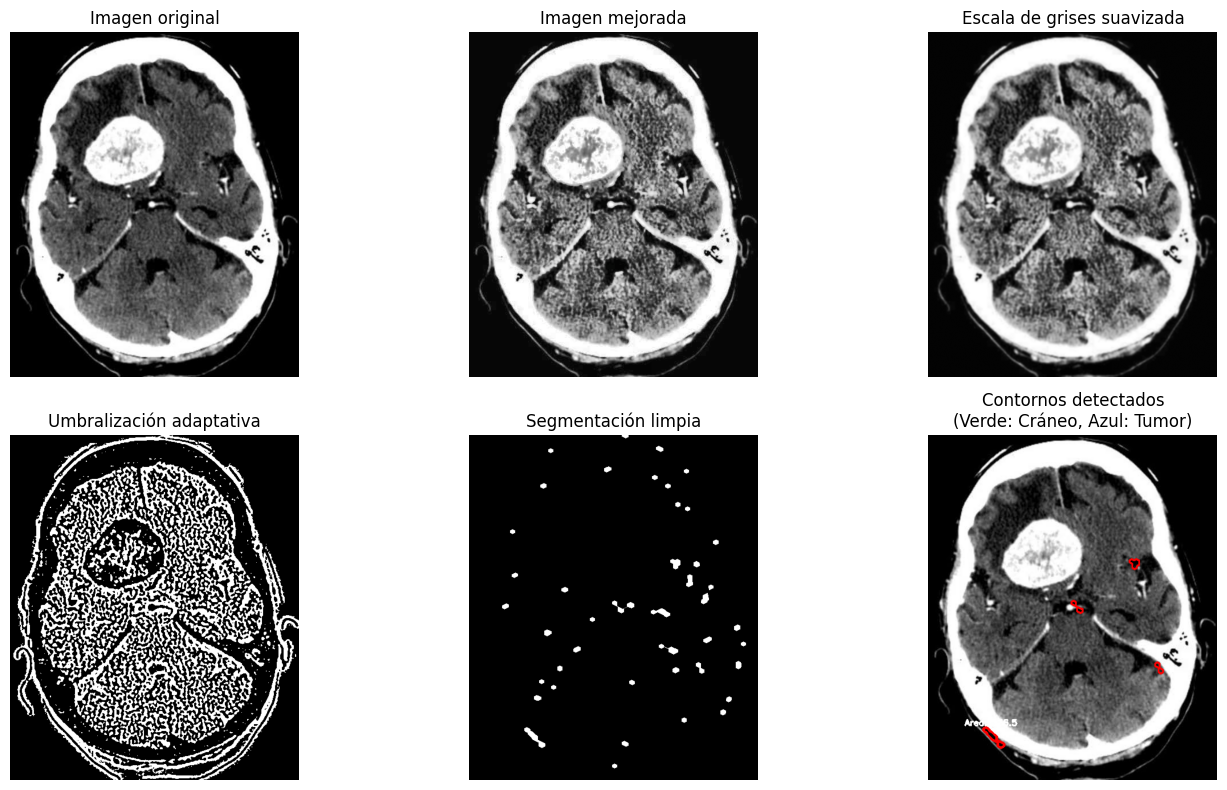

In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure

# Cargar imagen médica
img_path = 'platano.jpg'  # Cambiar por tu imagen
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 1. Mejorar contraste con CLAHE (Contrast Limited Adaptive Histogram Equalization)
lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
l, a, b = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
l_clahe = clahe.apply(l)
lab_clahe = cv2.merge((l_clahe,a,b))
img_enhanced = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

# 2. Convertir a escala de grises y suavizar
gray = cv2.cvtColor(img_enhanced, cv2.COLOR_RGB2GRAY)
gray_blur = cv2.GaussianBlur(gray, (5,5), 0)

# 3. Segmentación adaptativa
thresh = cv2.adaptiveThreshold(gray_blur, 255,
                             cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                             cv2.THRESH_BINARY_INV, 11, 2)

# 4. Operaciones morfológicas para limpiar
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=3)

# 5. Encontrar contornos
contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filtrar contornos por área y relación de aspecto
min_area = 100
max_area = 10000
tumor_contours = []
skull_contour = None

for cnt in contours:
    area = cv2.contourArea(cnt)
    if min_area < area < max_area:
        x,y,w,h = cv2.boundingRect(cnt)
        aspect_ratio = w/h

        # Criterios para tumor (ajustar según necesidad)
        if 0.7 < aspect_ratio < 1.5:  # Relación de aspecto cercana a 1 (circular/ovalado)
            tumor_contours.append(cnt)
        elif area > max_area/2:  # Contorno muy grande (probablemente cráneo)
            skull_contour = cnt

# 6. Dibujar resultados
result_img = img_rgb.copy()
if skull_contour is not None:
    cv2.drawContours(result_img, [skull_contour], -1, (0,255,0), 2)  # Cráneo en verde

for tumor_cnt in tumor_contours:
    cv2.drawContours(result_img, [tumor_cnt], -1, (255,0,0), 2)  # Tumores en azul

# 7. Calcular área del tumor principal
if tumor_contours:
    main_tumor = max(tumor_contours, key=cv2.contourArea)
    tumor_area = cv2.contourArea(main_tumor)
    print(f"Área del tumor detectado: {tumor_area} píxeles")

    # Dibujar contorno principal en rojo
    cv2.drawContours(result_img, [main_tumor], -1, (255,0,0), 3)

    # Calcular centroide
    M = cv2.moments(main_tumor)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cv2.putText(result_img, f"Area: {tumor_area}", (cX-50, cY-20),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)

# 8. Visualización
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
plt.imshow(img_rgb)
plt.title('Imagen original')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(img_enhanced)
plt.title('Imagen mejorada')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(gray_blur, cmap='gray')
plt.title('Escala de grises suavizada')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(thresh, cmap='gray')
plt.title('Umbralización adaptativa')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(cleaned, cmap='gray')
plt.title('Segmentación limpia')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(result_img)
plt.title('Contornos detectados\n(Verde: Cráneo, Azul: Tumor)')
plt.axis('off')

plt.tight_layout()
plt.show()